In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import save_model,load_model
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

#### Preprocess data

In [15]:
# Load your data
data = pd.read_csv('Dataset/pods_resource_data.csv',nrows=10010)  

# Convert timestamp to datetime
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

data = data.sort_values(by='Timestamp')

features = data[['CPU', 'Memory']]

# Normalize the data for model
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(features)

# LSTMs require sequential input because they learn from time dependencies in data, since single datapoint cnat provide enough info
# By creating sequences,  model can capture trends, seasonality, and patterns over time.
# This helps improve predictions by considering past values instead of treating each data point independently.
 
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 60  # we can adjust that (30, 60,90)
X, y = create_sequences(scaled_data, seq_length)

# Split into train and test
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

#### Model building

In [17]:
# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, activation="relu", return_sequences=True, input_shape=(seq_length, 2)))
# model.add(Dropout(0.2))  # Optional dropout to prevent overfitting
model.add(LSTM(units=50, activation="relu", return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM(units=50, activation="relu"))  
# model.add(Dropout(0.2))
model.add(Dense(units=2))  # Two outputs for CPU and Memory predictions
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, 
                    validation_data=(X_test, y_test), verbose=1)


Epoch 1/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - loss: 0.0311 - val_loss: 0.0294
Epoch 2/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - loss: 0.0291 - val_loss: 0.0294
Epoch 3/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - loss: 0.0291 - val_loss: 0.0291
Epoch 4/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - loss: 0.0280 - val_loss: 0.0247
Epoch 5/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - loss: 0.0237 - val_loss: 0.0239
Epoch 6/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - loss: 0.0215 - val_loss: 0.0211
Epoch 7/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0192 - val_loss: 0.0166
Epoch 8/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0161 - val_loss: 0.0129
Epoch 9/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - loss: 0.0150 - val_loss: 0.0090
Epoch 10/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - loss: 0.0117 - val_loss: 0.0081
Epoch 11/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 0.0102 - val_loss: 0.0076
Epoch 12/50
249/249 ━━━━━━━━━━━━

#### visualize loss

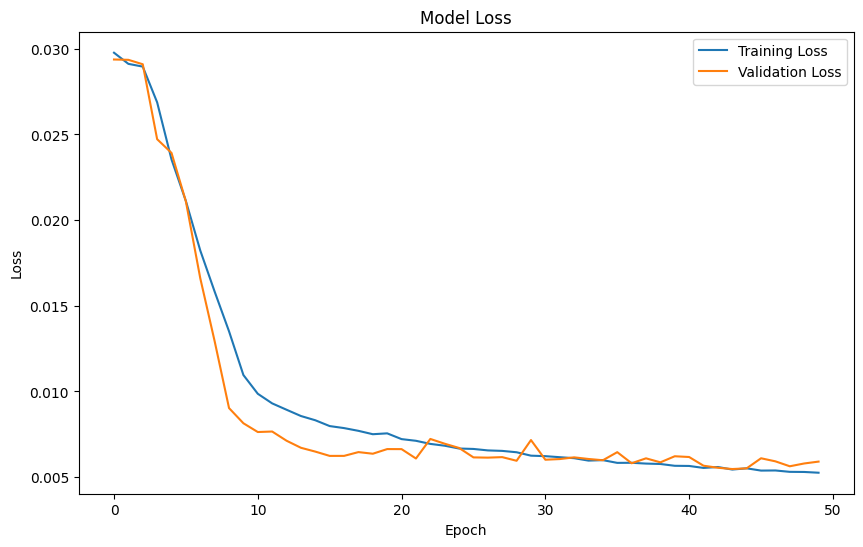

In [18]:
# Plot training & validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

#### actual vs predicted 

249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


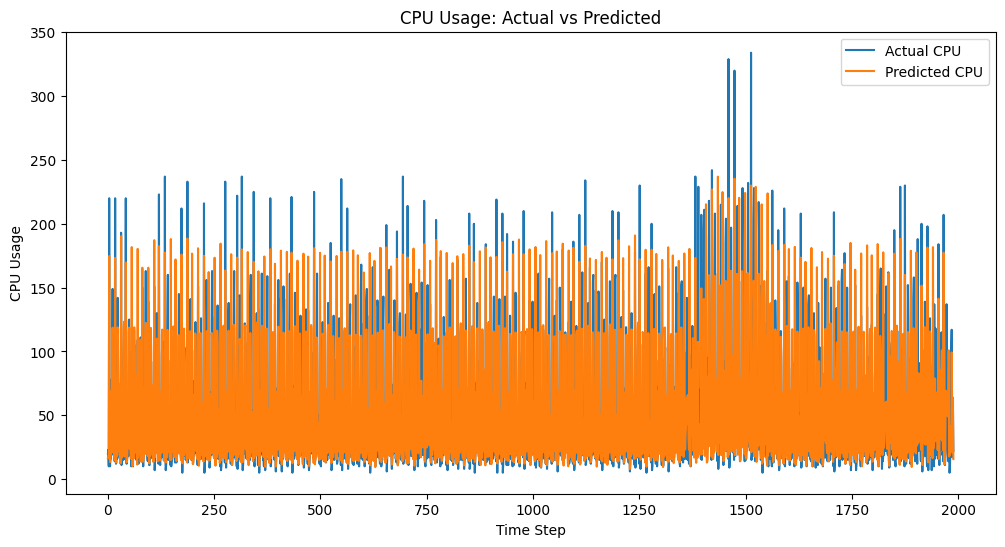

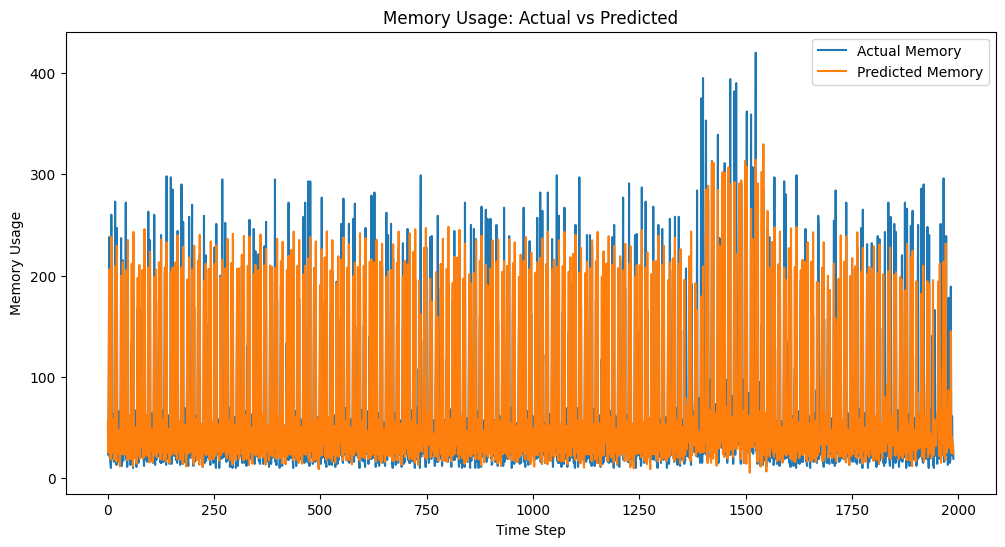

In [11]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the scaled data
train_predict = scaler.inverse_transform(train_predict)
y_train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform(y_test)

# Plot actual vs predicted for test data (CPU)
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual[:, 0], label='Actual CPU')
plt.plot(test_predict[:, 0], label='Predicted CPU')
plt.title('CPU Usage: Actual vs Predicted')
plt.xlabel('Time Step')
plt.ylabel('CPU Usage')
plt.legend()
plt.show()

# Plot actual vs predicted for test data (Memory)
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual[:, 1], label='Actual Memory')
plt.plot(test_predict[:, 1], label='Predicted Memory')
plt.title('Memory Usage: Actual vs Predicted')
plt.xlabel('Time Step')
plt.ylabel('Memory Usage')
plt.legend()
plt.show()

In [ ]:
# # Function to forecast future values
# def forecast_future(model, last_sequence, scaler, steps):
#     future = []
#     current_sequence = last_sequence.copy()
    
#     for _ in range(steps):
#         next_pred = model.predict(current_sequence.reshape(1, seq_length, -1))
#         future.append(next_pred[0])
#         current_sequence = np.roll(current_sequence, -1, axis=0)
#         current_sequence[-1] = next_pred
    
#     return scaler.inverse_transform(np.array(future))

# # Get the last sequence from the data
# last_sequence = scaled_data[-seq_length:]

# # Forecast for next 12 hours (assuming 20s intervals)
# future_steps = int(2 * 3600 / 20)  # 12 hours in 20s intervals
# forecast = forecast_future(model, last_sequence, scaler, future_steps)

# # Create timestamp for forecast
# last_timestamp = data['Timestamp'].iloc[-1]
# forecast_timestamps = pd.date_range(start=last_timestamp, periods=len(forecast)+1, freq='20s')[1:]

# # Plot forecast
# plt.figure(figsize=(12, 6))
# plt.plot(forecast_timestamps, forecast[:, 0], label='Forecasted CPU')
# plt.plot(forecast_timestamps, forecast[:, 1], label='Forecasted Memory')
# plt.title('Resource Usage Forecast')
# plt.xlabel('Timestamp')
# plt.ylabel('Usage')
# plt.legend()
# plt.show()

### Forecasing for single pod

In [20]:
# Why use confidence intervals?

#     Uncertainty Quantification: shows range of plausible values
#     Risk Assessment: Helps understand potential extremes
#     Model Reliability: Wider intervals indicate less confidence
#     Decision Making: Critical for capacity planning
def forecast_future_with_confidence(model, last_sequence, scaler, steps, confidence_level=0.95):
    future = []
    lower_bounds = []
    upper_bounds = []
    current_sequence = last_sequence.copy()
    
    for _ in range(steps):
        # Predict next value
        next_pred = model.predict(current_sequence.reshape(1, seq_length, -1))
        future.append(next_pred[0])
        
        # Estimate confidence interval (simplified approach)
        std_dev = np.std(future) if len(future) > 1 else 0.1
        margin = std_dev * (1.96 / np.sqrt(len(future)+1))  # Approximation for 95% confidence
        
        lower_bounds.append(next_pred[0] - margin)
        upper_bounds.append(next_pred[0] + margin)
        
        # Update the sequence
        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1] = next_pred
    
    # scaled data into original form
    future = scaler.inverse_transform(np.array(future))
    lower_bounds = scaler.inverse_transform(np.array(lower_bounds))
    upper_bounds = scaler.inverse_transform(np.array(upper_bounds))
    
    return future, lower_bounds, upper_bounds

In [22]:
# Get the last sequence from the data
last_sequence = scaled_data[-seq_length:]

# Forecast for next 12 hours (assuming 20s intervals)
future_steps = int(1 * 3600 / 20)  # 12 hours in 20s intervals
forecast, lower_bounds, upper_bounds = forecast_future_with_confidence(model, last_sequence, scaler, future_steps)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━

In [24]:
# Create timestamp for forecast
last_timestamp = data['Timestamp'].iloc[-1]
forecast_timestamps = pd.date_range(start=last_timestamp, periods=len(forecast)+1, freq='20s')[1:]

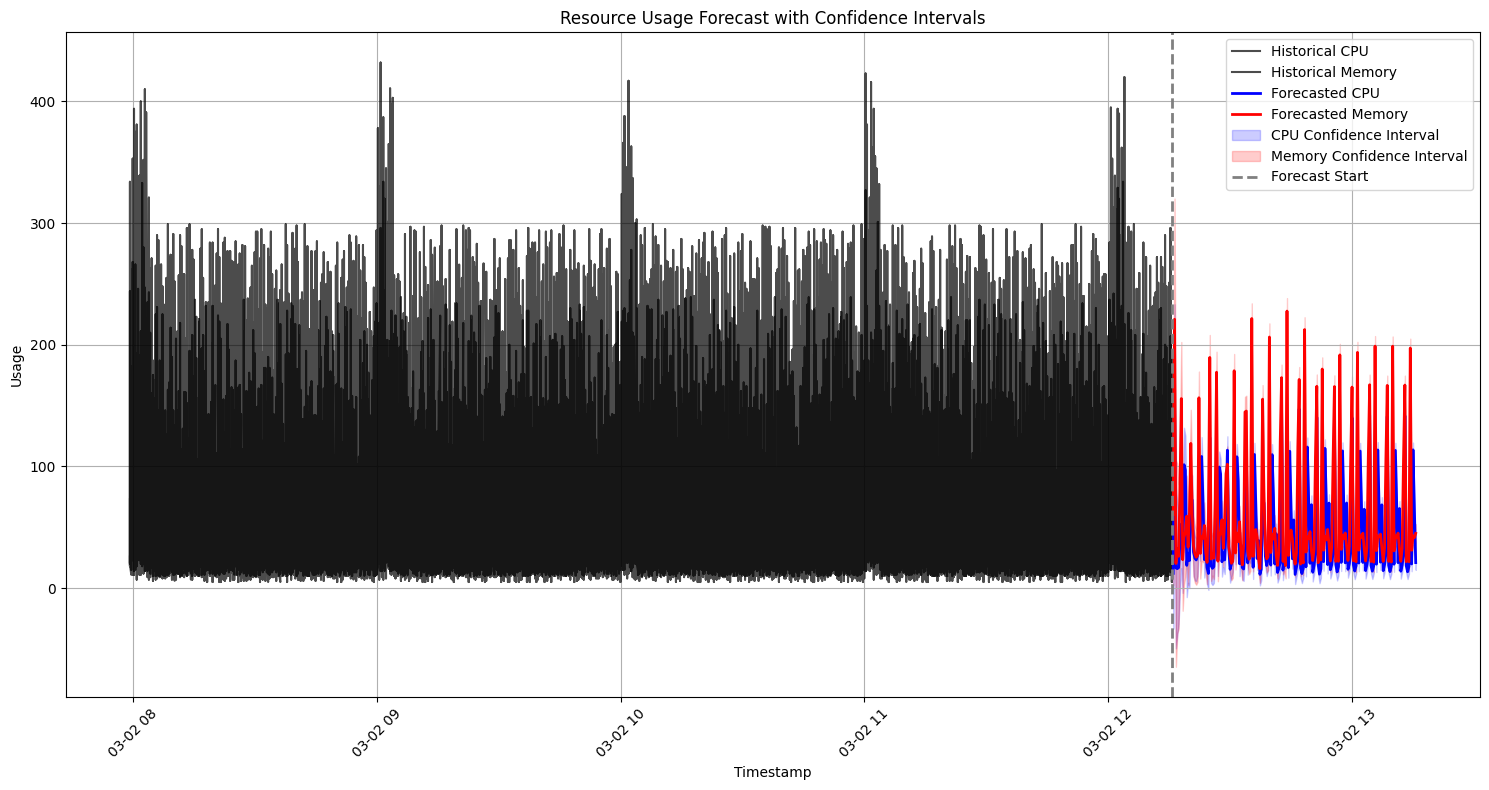

In [26]:
historical_timestamps = data['Timestamp']
historical_cpu = data['CPU']
historical_memory = data['Memory']

# Plot forecast with confidence intervals
plt.figure(figsize=(15, 8))

plt.plot(historical_timestamps, historical_cpu, 'k-', alpha=0.7, label='Historical CPU')
plt.plot(historical_timestamps, historical_memory, 'k-', alpha=0.7, label='Historical Memory')

plt.plot(forecast_timestamps, forecast[:, 0], 'b-', linewidth=2, label='Forecasted CPU')
plt.plot(forecast_timestamps, forecast[:, 1], 'r-', linewidth=2, label='Forecasted Memory')

# Plot confidence intervals
plt.fill_between(forecast_timestamps, lower_bounds[:, 0], upper_bounds[:, 0], 
                 color='blue', alpha=0.2, label='CPU Confidence Interval')
plt.fill_between(forecast_timestamps, lower_bounds[:, 1], upper_bounds[:, 1], 
                 color='red', alpha=0.2, label='Memory Confidence Interval')

plt.axvline(x=last_timestamp, color='gray', linestyle='--', linewidth=2, label='Forecast Start')

# Add labels and legend
plt.xlabel('Timestamp')
plt.ylabel('Usage')
plt.title('Resource Usage Forecast with Confidence Intervals')
plt.legend()
plt.grid(True)

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Build Model for all pods
#### Data Preprocess and Model BUilding

Epoch 1/100
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 47s 37ms/step - loss: 0.0261 - val_loss: 0.0101
Epoch 2/100
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 44s 35ms/step - loss: 0.0092 - val_loss: 0.0063
Epoch 3/100
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 44s 35ms/step - loss: 0.0066 - val_loss: 0.0055
Epoch 4/100
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 44s 35ms/step - loss: 0.0058 - val_loss: 0.0060
Epoch 5/100
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 44s 35ms/step - loss: 0.0054 - val_loss: 0.0053
Epoch 6/100
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 44s 35ms/step - loss: 0.0052 - val_loss: 0.0047
Epoch 7/100
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 44s 35ms/step - loss: 0.0049 - val_loss: 0.0044
Epoch 8/100
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 44s 36ms/step - loss: 0.0048 - val_loss: 0.0048
Epoch 9/100
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 44s 36ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 10/100
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 44s 36ms/step - loss: 0.0042 - val_loss: 0.0039
Epoch 11/100
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 45s 36ms/step - loss: 0.0040 - val_loss: 0.00

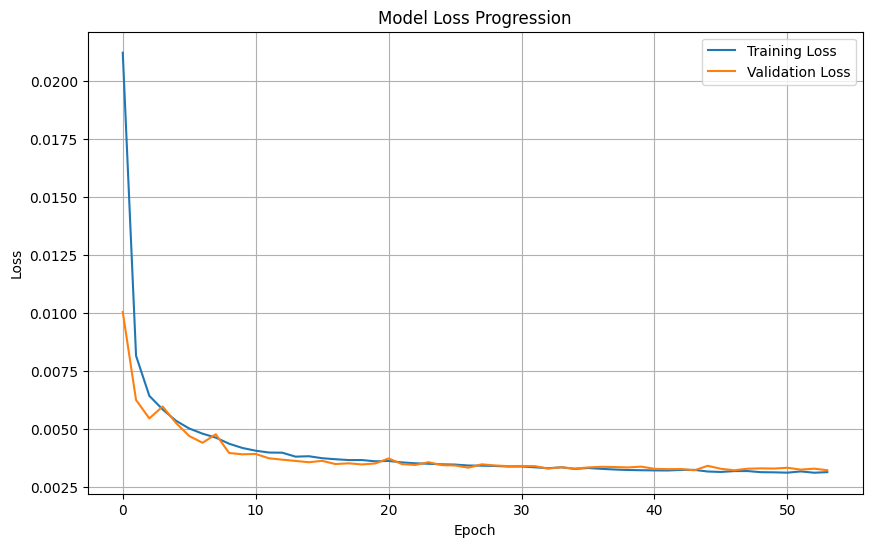

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
CPU Metrics - MAE: 10.30, RMSE: 18.33
Memory Metrics - MAE: 12.19, RMSE: 24.58


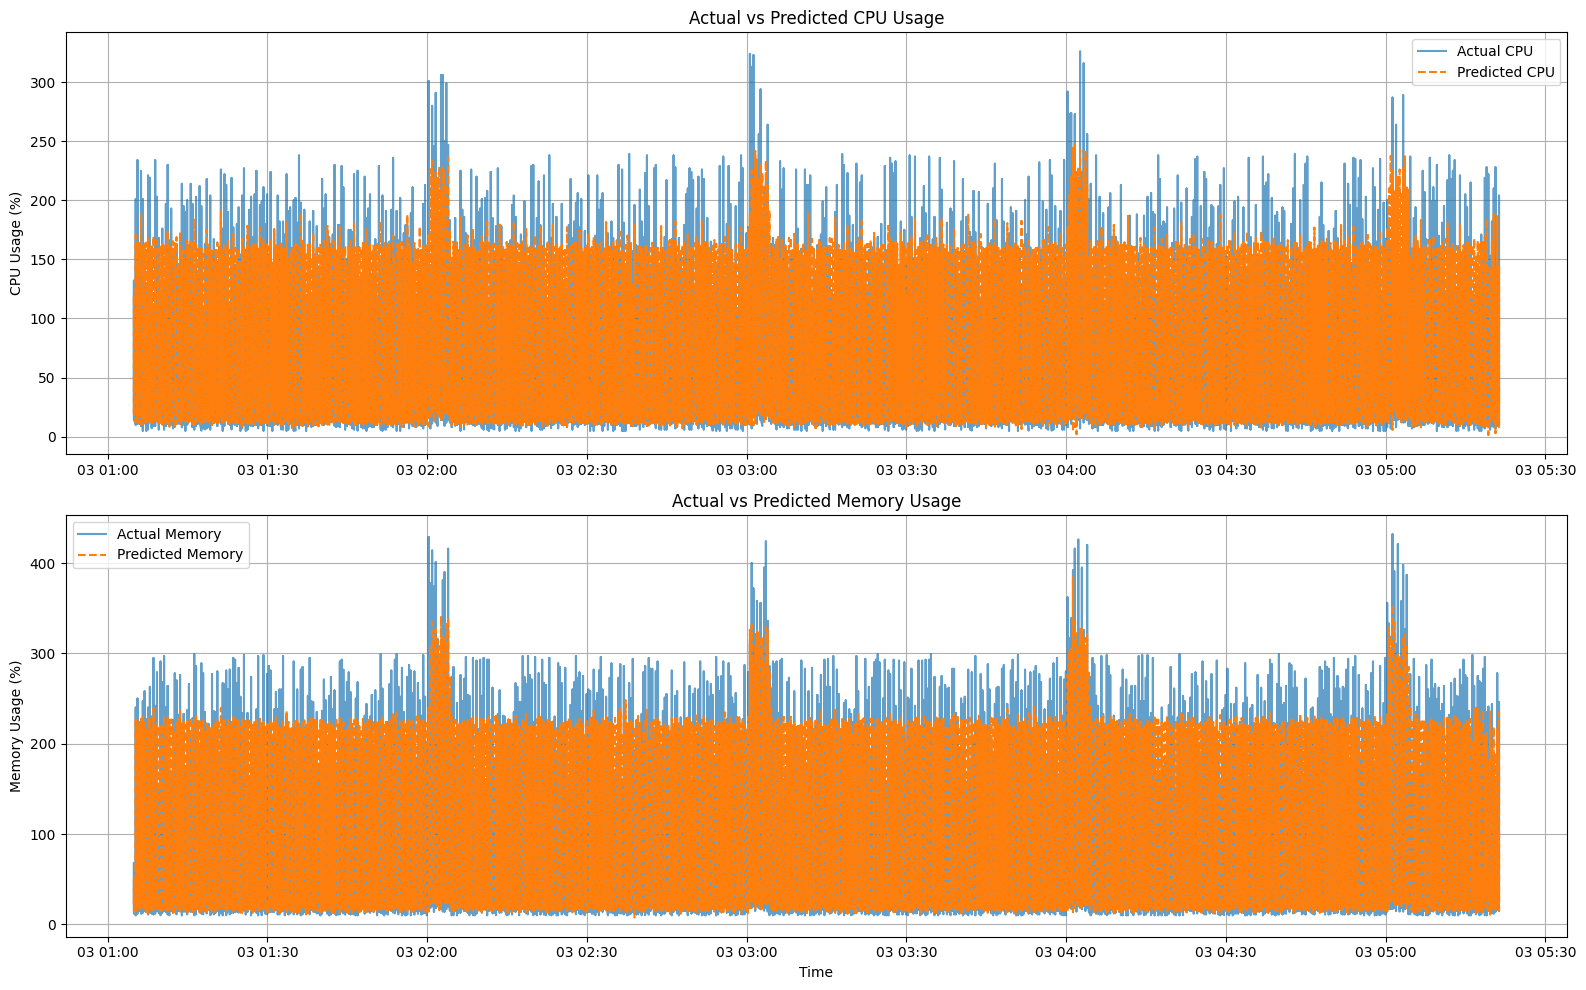

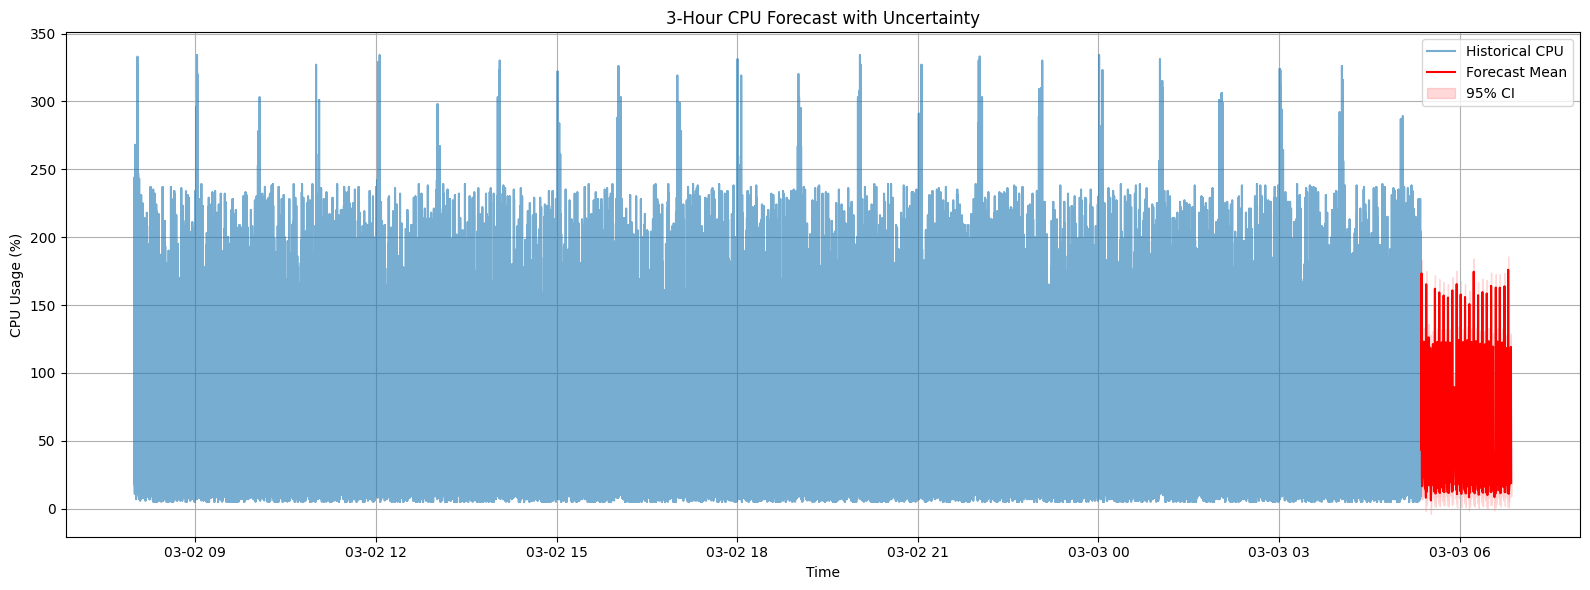

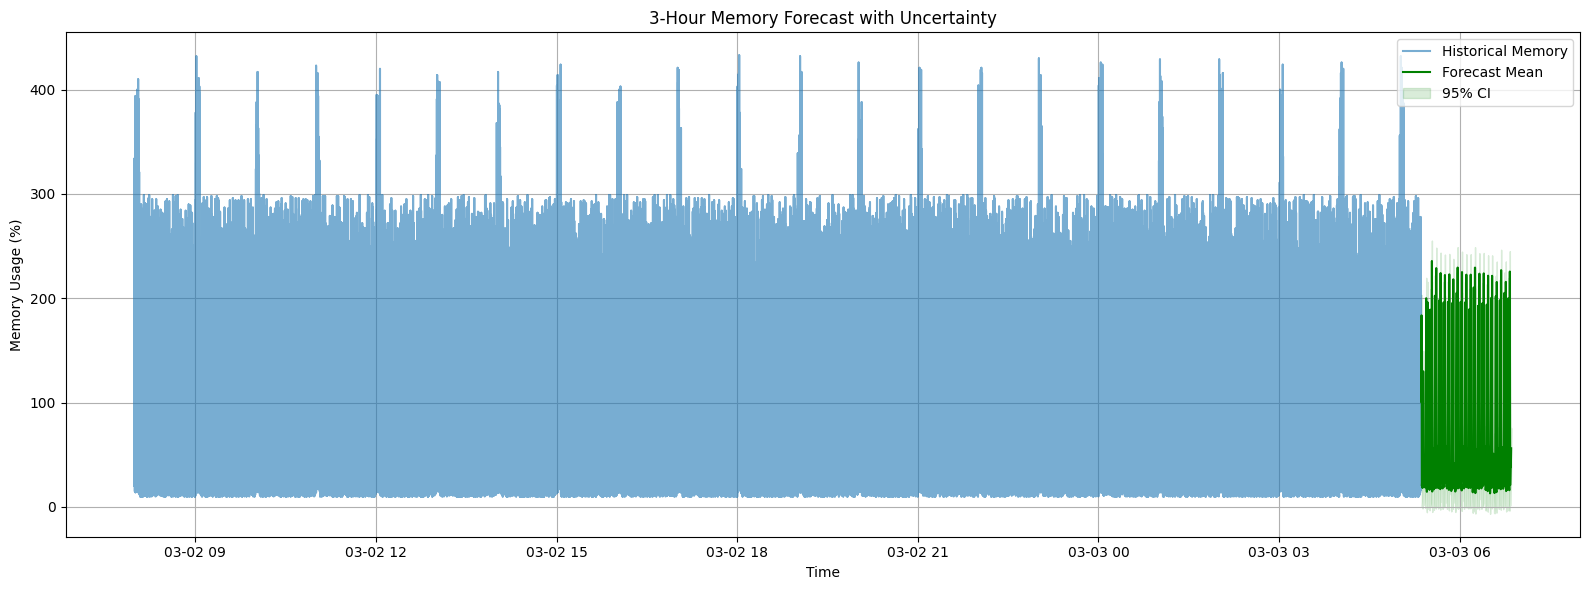

In [6]:
# 1. Data Preparation
df = pd.read_csv("Dataset/pods_resource_data.csv", nrows=50011)
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df = df.sort_values("Timestamp")

train_size = int(len(df) * 0.8)
test_size = len(df) - train_size

# Normalization
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[["CPU", "Memory"]])

# Sequence creation
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 60
X_train, y_train = create_sequences(scaled_data[:train_size], SEQ_LENGTH)
X_test, y_test = create_sequences(scaled_data[train_size - SEQ_LENGTH:], SEQ_LENGTH)

# 2. Model Architecture
model = Sequential([
    LSTM(128, activation="relu", return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])),
    # Dropout(0.2),
    LSTM(64, activation="relu"),
    # LSTM(32, activation="relu"),
    Dense(2)
])
model.compile(optimizer="adam", loss="mse")

# 3. Training with Early Stopping
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

In [12]:
model.save("model_1.keras")  # Saves model file
model =load_model("model_1.keras")

#### 4. Plot Training and Validation 
#### 5. Plot Actual vs predicted
#### 6. Forecastig and visualize

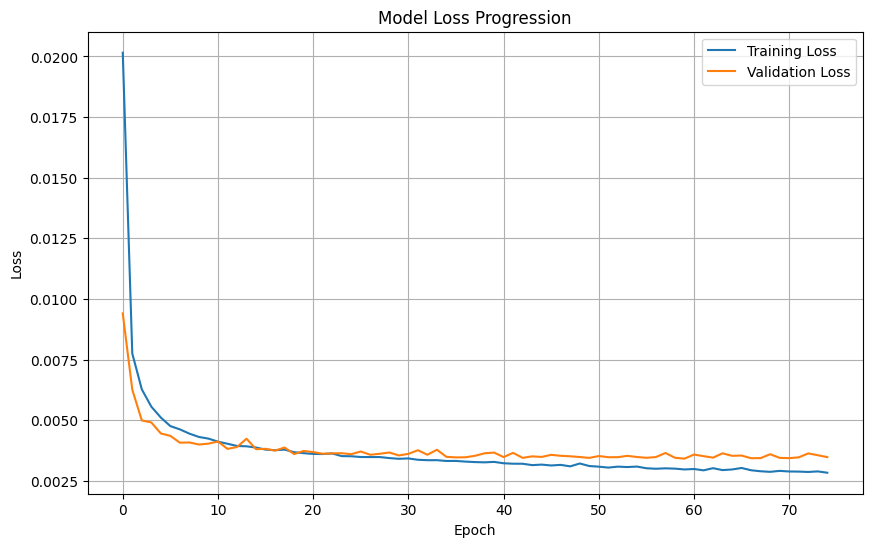

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
CPU Metrics - MAE: 10.35, RMSE: 18.76
Memory Metrics - MAE: 12.31, RMSE: 25.75


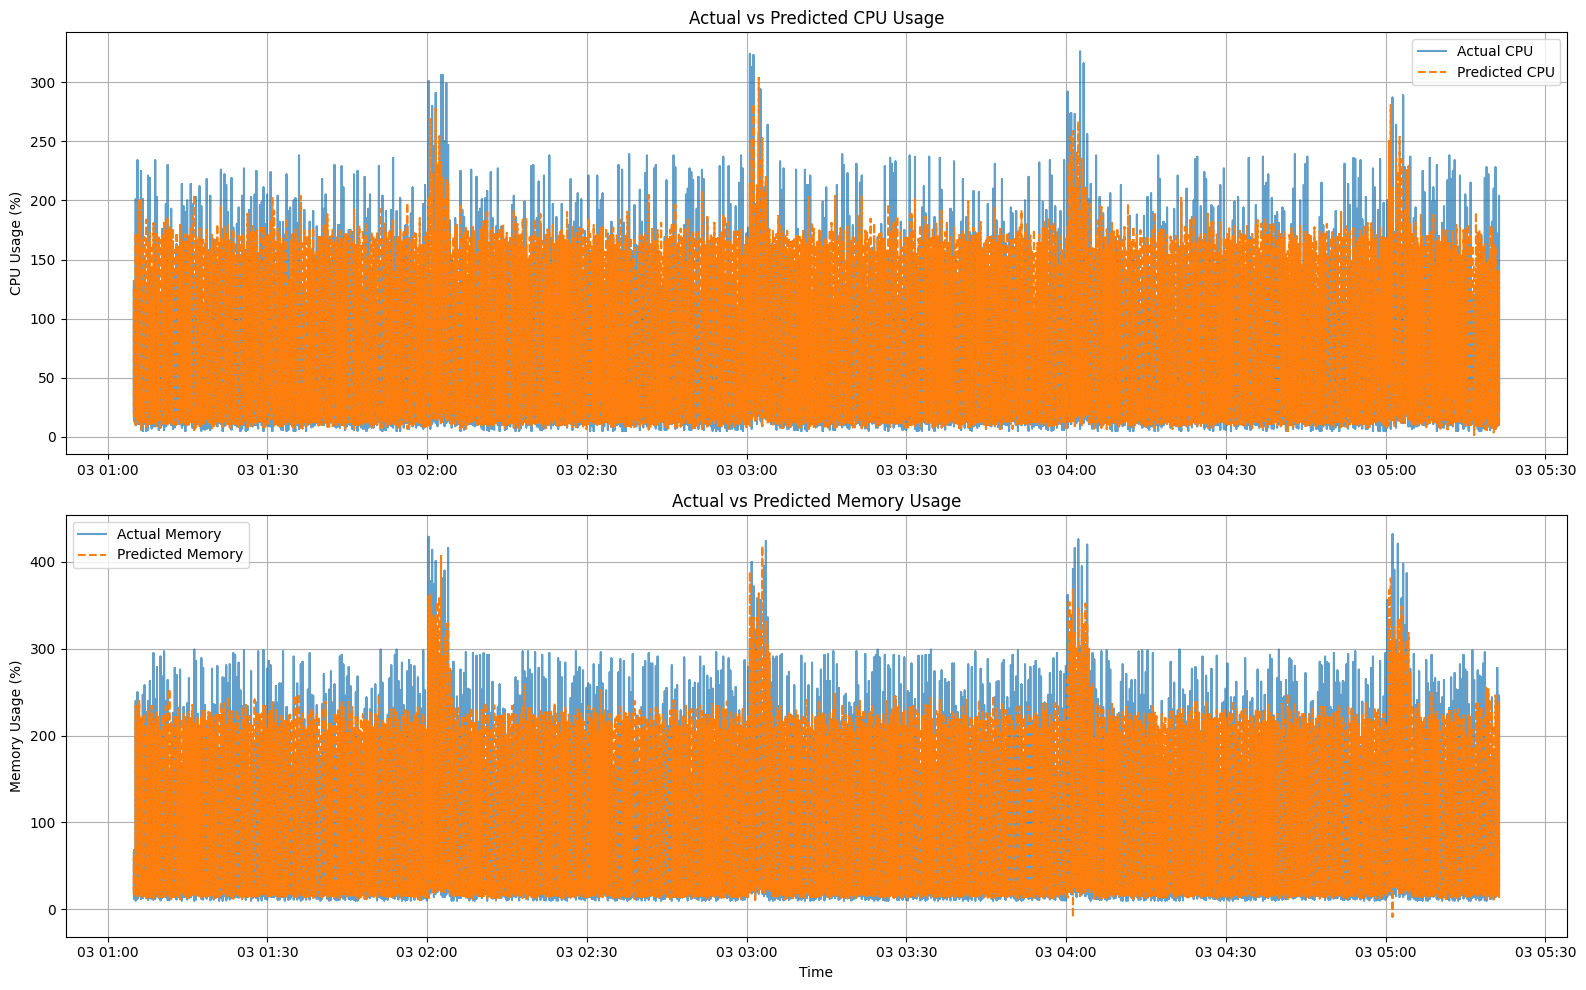

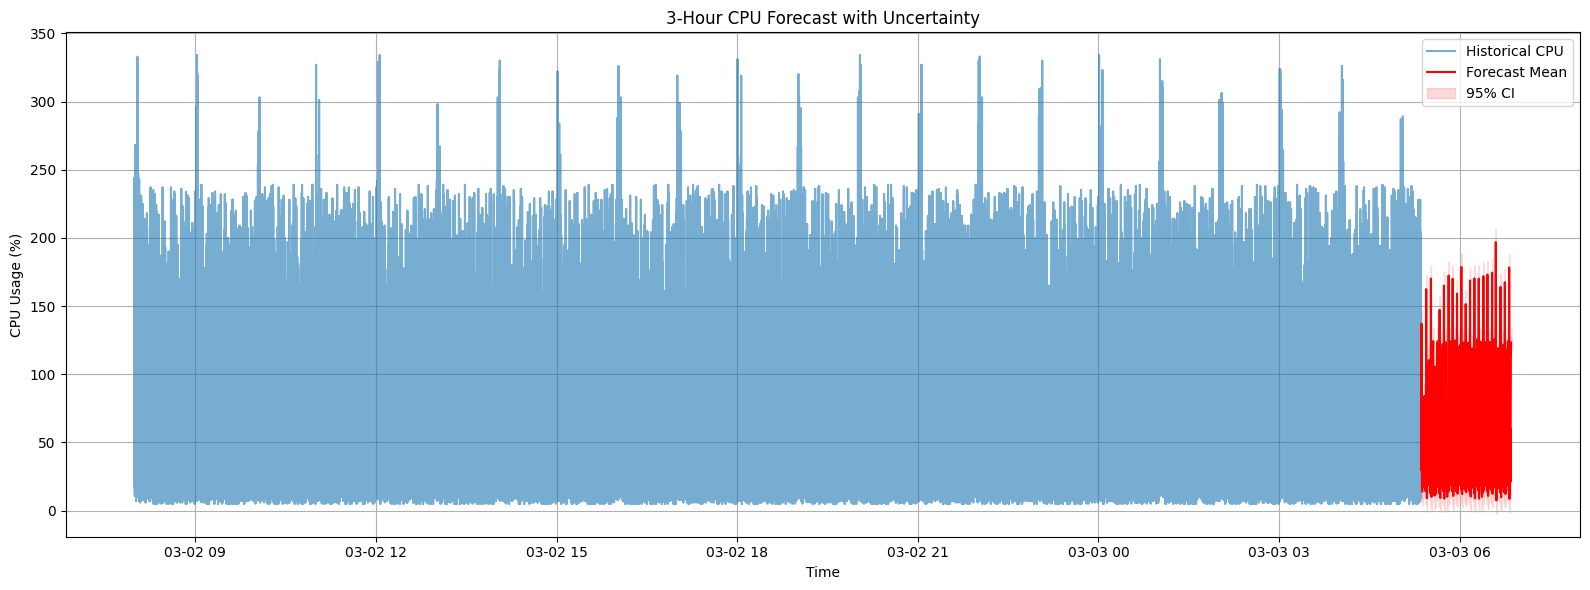

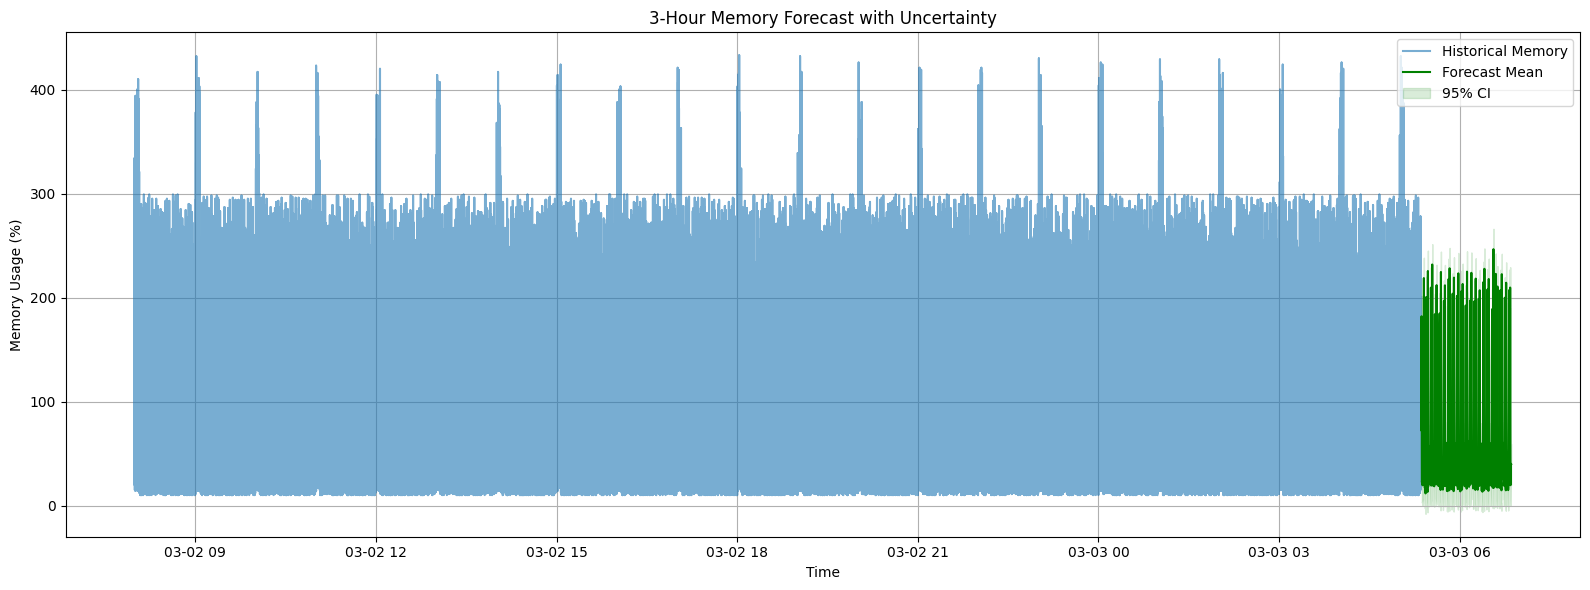

In [13]:
# 4. Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

# 5. Actual vs Predicted on Test Set
y_pred = model.predict(X_test)

# Inverse scaling
y_test_actual = scaler.inverse_transform(y_test)
y_pred_actual = scaler.inverse_transform(y_pred)

# Calculate metrics
cpu_mae = mean_absolute_error(y_test_actual[:, 0], y_pred_actual[:, 0])
cpu_rmse = np.sqrt(mean_squared_error(y_test_actual[:, 0], y_pred_actual[:, 0]))

mem_mae = mean_absolute_error(y_test_actual[:, 1], y_pred_actual[:, 1])
mem_rmse = np.sqrt(mean_squared_error(y_test_actual[:, 1], y_pred_actual[:, 1]))

print(f"CPU Metrics - MAE: {cpu_mae:.2f}, RMSE: {cpu_rmse:.2f}")
print(f"Memory Metrics - MAE: {mem_mae:.2f}, RMSE: {mem_rmse:.2f}")

# 6. Visualization: Actual vs Predicted
test_timestamps = df["Timestamp"].iloc[train_size:train_size + len(y_test)]

plt.figure(figsize=(16, 10))

# CPU Plot
plt.subplot(2, 1, 1)
plt.plot(test_timestamps, y_test_actual[:, 0], label="Actual CPU", alpha=0.7)
plt.plot(test_timestamps, y_pred_actual[:, 0], label="Predicted CPU", linestyle="--")
plt.title("Actual vs Predicted CPU Usage")
plt.ylabel("CPU Usage (%)")
plt.legend()
plt.grid(True)

# Memory Plot
plt.subplot(2, 1, 2)
plt.plot(test_timestamps, y_test_actual[:, 1], label="Actual Memory", alpha=0.7)
plt.plot(test_timestamps, y_pred_actual[:, 1], label="Predicted Memory", linestyle="--")
plt.title("Actual vs Predicted Memory Usage")
plt.ylabel("Memory Usage (%)")
plt.xlabel("Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Forecasting Function
def fast_forecast(model, last_sequence, steps, num_samples=30):
    forecasts = np.zeros((num_samples, steps, 2))
    current_seqs = np.tile(last_sequence, (num_samples, 1, 1))
    
    for step in range(steps):
        preds = model.predict(current_seqs, verbose=0)
        forecasts[:, step] = preds
        current_seqs = np.concatenate([current_seqs[:, 1:], preds.reshape(num_samples, 1, 2)], axis=1)
    
    return np.mean(forecasts, axis=0), np.std(forecasts, axis=0)

# 8. Generate Forecast
FUTURE_STEPS = 270
mean_forecast, std_forecast = fast_forecast(model, X_test[-1], FUTURE_STEPS)

# Inverse scaling
mean_actual = scaler.inverse_transform(mean_forecast)
std_actual = scaler.inverse_transform(std_forecast)

# 9. Forecast Visualization
forecast_times = pd.date_range(
    start=df["Timestamp"].iloc[-1] + pd.Timedelta(seconds=20),
    periods=FUTURE_STEPS,
    freq="20s"
)

# CPU Forecast Plot
plt.figure(figsize=(16, 6))
plt.plot(df["Timestamp"], df["CPU"], label="Historical CPU", alpha=0.6)
plt.plot(forecast_times, mean_actual[:, 0], label="Forecast Mean", color="red")
plt.fill_between(forecast_times,
                 mean_actual[:, 0] - 1.96*std_actual[:, 0],
                 mean_actual[:, 0] + 1.96*std_actual[:, 0],
                 color="red", alpha=0.15, label="95% CI")
plt.title("3-Hour CPU Forecast with Uncertainty")
plt.xlabel("Time")
plt.ylabel("CPU Usage (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Memory Forecast Plot
plt.figure(figsize=(16, 6))
plt.plot(df["Timestamp"], df["Memory"], label="Historical Memory", alpha=0.6)
plt.plot(forecast_times, mean_actual[:, 1], label="Forecast Mean", color="green")
plt.fill_between(forecast_times,
                 mean_actual[:, 1] - 1.96*std_actual[:, 1],
                 mean_actual[:, 1] + 1.96*std_actual[:, 1],
                 color="green", alpha=0.15, label="95% CI")
plt.title("3-Hour Memory Forecast with Uncertainty")
plt.xlabel("Time")
plt.ylabel("Memory Usage (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
# # 1. Data Preparation for 47-hour time series
# df = pd.read_csv("data_files/pods_resource_data.csv", nrows=50011)
# df["Timestamp"] = pd.to_datetime(df["Timestamp"])
# df = df.sort_values("Timestamp")

# # Time-based split (maintain temporal order)
# train_size = int(len(df) * 0.8)  # First 80% for training
# test_size = len(df) - train_size  # Last 20% for testing

# # Normalization
# scaler = MinMaxScaler()
# scaled_data = scaler.fit_transform(df[["CPU", "Memory"]])

# # Sequence creation function
# def create_sequences(data, seq_length):
#     X, y = [], []
#     for i in range(len(data) - seq_length):
#         X.append(data[i:i+seq_length])
#         y.append(data[i+seq_length])
#     return np.array(X), np.array(y)

# SEQ_LENGTH = 60  # 20 minutes history (60*20s = 1200s)
# X_train, y_train = create_sequences(scaled_data[:train_size], SEQ_LENGTH)
# X_test, y_test = create_sequences(scaled_data[train_size - SEQ_LENGTH:], SEQ_LENGTH)

# # 2. Enhanced Model with Early Stopping
# model = Sequential([
#     LSTM(128, activation="relu", return_sequences=True, 
#         input_shape=(X_train.shape[1], X_train.shape[2])),
#     LSTM(64,activation="relu"),
#     Dense(2)
# ])

# model.compile(optimizer="adam", loss="mse")

# # Early stopping callback
# early_stop = EarlyStopping(
#     monitor="val_loss",
#     patience=15,
#     verbose=1
# )

# # Train with validation
# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_test, y_test),
#     epochs=100,
#     batch_size=32,
#     callbacks=[early_stop],
#     verbose=2
# )

In [15]:
# model.save("model.keras")  # Saves as a single file
# model =load_model("model.keras") 

In [14]:
# # 7. Optimized Forecasting Function (3-5x Faster)
# def fast_forecast(model, last_sequence, steps, num_samples=30):
#     """Vectorized forecasting with parallel sampling"""
#     # Pre-allocate memory
#     forecasts = np.zeros((num_samples, steps, 2))
#     current_seqs = np.tile(last_sequence, (num_samples, 1, 1))
    
#     for step in range(steps):
#         # Batch predict all samples at once
#         preds = model.predict(current_seqs, verbose=0)
#         forecasts[:, step] = preds
        
#         # Vectorized sequence update
#         current_seqs = np.concatenate([
#             current_seqs[:, 1:], 
#             preds.reshape(num_samples, 1, 2)
#         ], axis=1)
    
#     return np.mean(forecasts, axis=0), np.std(forecasts, axis=0)

# # 8. Generate Forecast
# FUTURE_STEPS = 270  # 3 hours
# mean_forecast, std_forecast = fast_forecast(
#     model=model,
#     last_sequence=X_test[-1],
#     steps=FUTURE_STEPS
# )

# # 9. Inverse Scaling
# mean_actual = scaler.inverse_transform(mean_forecast)
# std_actual = scaler.inverse_transform(std_forecast)

# # 10. Visualization
# plt.figure(figsize=(16, 8))

# # Training/Validation Loss
# plt.subplot(2, 1, 1)
# plt.plot(history.history["loss"], label="Train Loss")
# plt.plot(history.history["val_loss"], label="Validation Loss")
# plt.title("Training Progress")
# plt.ylabel("MSE Loss")
# plt.legend()
# plt.grid(True)

# # CPU Forecast
# plt.subplot(2, 1, 2)
# forecast_times = pd.date_range(
#     start=df["Timestamp"].iloc[-1] + pd.Timedelta(seconds=20),
#     periods=FUTURE_STEPS,
#     freq="20S"
# )

# plt.plot(df["Timestamp"], df["CPU"], label="Historical CPU", alpha=0.6)
# plt.plot(forecast_times, mean_actual[:,0], label="Forecast Mean", color="red")
# plt.fill_between(
#     forecast_times,
#     mean_actual[:,0] - 1.96*std_actual[:,0],
#     mean_actual[:,0] + 1.96*std_actual[:,0],
#     color="red",
#     alpha=0.15,
#     label="95% CI"
# )

# plt.title("3-Hour CPU Forecast with Uncertainty")
# plt.xlabel("Time")
# plt.ylabel("CPU Usage (%)")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # NEW MEMORY FORECAST VISUALIZATION
# plt.figure(figsize=(16, 8))
# plt.plot(df["Timestamp"], df["Memory"], label="Historical Memory", alpha=0.6)
# plt.plot(forecast_times, mean_actual[:,1], label="Forecast Mean", color="green")
# plt.fill_between(
#     forecast_times,
#     mean_actual[:,1] - 1.96*std_actual[:,1],
#     mean_actual[:,1] + 1.96*std_actual[:,1],
#     color="green",
#     alpha=0.15,
#     label="95% CI"
# )

# plt.title("3-Hour Memory Forecast with Uncertainty")
# plt.xlabel("Time")
# plt.ylabel("Memory Usage (%)")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
